In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import cv2 as cv
from torchvision.transforms import ToTensor
from torch_snippets import Report
import numpy as np
import torch.utils.data
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)


In [92]:
piece_lookup = {
    0 : "K",
    1 : "Q",
    2 : "R",
    3 : "B",
    4 : "N",
    5 : "P",
    6 : "k",
    7 : "q",
    8 : "r",
    9 : "b",
    10 : "n",
    11 : "p",
    6 : "1",
}

value_lookup = {
    "K" : 0,
    "Q" : 1,
    "R" : 2,
    "B" : 3,
    "N" : 4,
    "P" : 5,
    "k" : 6,
    "q" : 7,
    "r" : 8,
    "b" : 9,
    "n" : 10,
    "p" : 11,
}

def y_to_fens(results):
    fens = []

    for i in range(results.shape[0]):
        fen = ''
        empty = 0

        for j in range(64):
            if np.argmax(results[i, j, :]) == 12:
                empty += 1
            else:
                if empty != 0:
                    fen += str(empty)
                    empty = 0
                piece_idx = np.argmax(results[i, j, :])
                fen += piece_lookup[piece_idx]

            if (j+1) % 8 == 0 and j < 63:
                if empty != 0:
                    fen += str(empty)
                    empty = 0
                fen += '/'

        fens.append(fen)
    
    return fens

def fens_to_y(fens):
    results = np.zeros((len(fens), 64, 13))

    for i, fen in enumerate(fens):

        fen = fen.split()[0]
        
        rows = fen.split('/')
        col = 0
        for j, row in enumerate(rows):  
            for char in row:
                if char.isdigit():
                    aux = col + int(char)
                    results[i, col:aux, 12] = 1
                    col = aux
                else:
                    piece_idx = value_lookup[char]
                    results[i, col, piece_idx] = 1
                    col += 1

    return results

In [93]:
class PieceImageClassifier(nn.Module):
    def __init__(self):
        super(PieceImageClassifier, self).__init__()

        self.model = models.mobilenet_v2(weights="MobileNet_V2_Weights.DEFAULT")

        self.model.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), 
            nn.Flatten(),
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )

    def forward(self, x):
        aux = self.model.features(x)
        outputs = self.model.classifier(aux)
        return outputs

class GamesDataset(Dataset):
    def __init__(self, images, fen):
        self.x = images
        self.y = torch.from_numpy(fen).type(torch.FloatTensor)
        self.n_samples = images.shape[0]
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return self.n_samples

In [94]:
imagens_array = torch.load("Dataset\Pecas\imagens_casa_tensor10000.pt")
fens = np.load("Dataset\Pecas\pecas_casa_tensor10000.npy")
for i in range(20000, 30001, 10000):
    imagens_array_load = torch.load(f"Dataset\Pecas\imagens_casa_tensor{i}.pt")
    fens_load = np.load(f"Dataset\Pecas\pecas_casa_tensor{i}.npy")

    imagens_array = torch.cat((imagens_array, imagens_array_load), dim=0)
    fens = np.concatenate((fens, fens_load), axis=0)


print(imagens_array.size())
print(fens.shape)

torch.Size([30000, 3, 224, 224])
(30000, 6)


In [95]:
class_frequencies  = np.sum(fens, axis=0)

class_frequencies = torch.from_numpy(class_frequencies)

weights = torch.tensor([0.1, 0.15, 0.15, 0.15, 0.25, 0.2])

print(class_frequencies)
print(weights)

datasetTrain = GamesDataset(imagens_array[:int(len(imagens_array)*.95)], fens[:int(len(fens)*.95)])

sampler = WeightedRandomSampler(weights, 1500, replacement = True )

dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=32)

datasetTest = GamesDataset(imagens_array[int(len(imagens_array)*.95):], fens[int(len(fens)*.95):])
dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=32)

print(f"Train: {len(dataLoaderTrain.dataset)}")
print(f"Test: {len(dataLoaderTest.dataset)}")

tensor([4615, 4705, 5319, 7234, 3410, 4717], dtype=torch.int32)
tensor([0.1000, 0.1500, 0.1500, 0.1500, 0.2500, 0.2000])
Train: 28500
Test: 1500


In [102]:
model = PieceImageClassifier()
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

In [103]:
num_epochs = 6
log = Report(num_epochs)


for epoch in range(num_epochs):

    model.train()        
    N = len(dataLoaderTrain)
    for bx, data in enumerate(dataLoaderTrain):
        total = 0
        right = 0

        pos, fen_y = data

        pos = pos.to(device)
        fen_y = fen_y.to(device)

        fen_pred = model(pos)

        loss = criterion(fen_pred, fen_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        fen_pred = fen_pred.cpu().detach().numpy().astype('float32')
        fen_y = fen_y.cpu().detach().numpy().astype('float32')

        for i in range(len(fen_pred)):
            total += 1            
            if np.argmax(fen_pred[i, :]) == np.argmax(fen_y[i, :]):
                right += 1

    
        accuracy_train = right/total * 100

        log.record((epoch+(bx+1)/N), trn_loss=loss, trn_acc=accuracy_train, end='\r')



    model.eval()
    with torch.no_grad():                
        N = len(dataLoaderTest)
        for bx, data in enumerate(dataLoaderTest):
            total = 0
            right = 0

            pos, fen_y = data

            pos = pos.to(device)
            fen_y = fen_y.to(device)

            fen_pred = model(pos)

            loss_test = criterion(fen_pred, fen_y)

            fen_pred = fen_pred.cpu().detach().numpy().astype('float32')
            fen_y = fen_y.cpu().detach().numpy().astype('float32')

            for i in range(len(fen_pred)):
                total += 1                
                if np.argmax(fen_pred[i, :]) == np.argmax(fen_y[i, :]):
                    right += 1

            accuracy_test = right/total * 100


            log.record((epoch+(bx+1)/N), val_loss=loss, val_acc=accuracy_test, end='\r')
    
    if (epoch+1)%2==0: log.report_avgs(epoch+1)
    lr_scheduler.step()


torch.save(model.state_dict(), 'Mestrado/Models/imageClassifier.pth')


EPOCH: 2.000  trn_acc: 93.376  val_loss: 0.964  trn_loss: 1.178  val_acc: 96.998  (224.71s - 449.43s remaining)
EPOCH: 4.000  trn_acc: 99.523  val_loss: 0.299  trn_loss: 0.372  val_acc: 98.072  (449.50s - 224.75s remaining)
EPOCH: 6.000  trn_acc: 99.562  val_loss: 0.121  trn_loss: 0.132  val_acc: 98.138  (674.76s - 0.00s remaining)


100%|██████████| 107/107 [00:00<00:00, 981.43it/s]


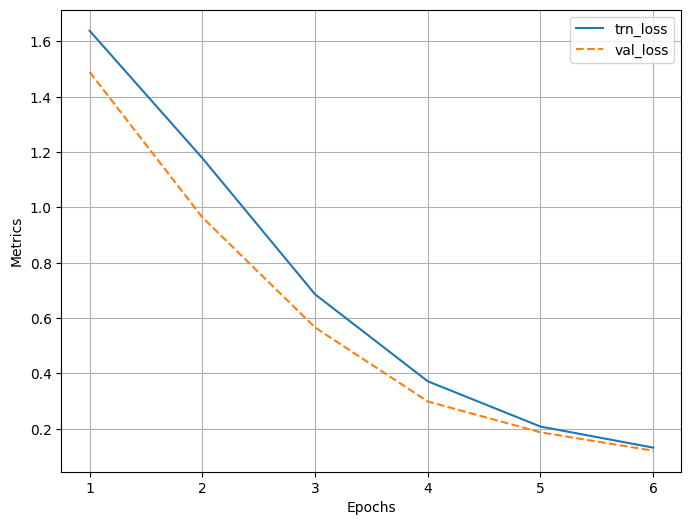

100%|██████████| 107/107 [00:00<00:00, 1150.28it/s]


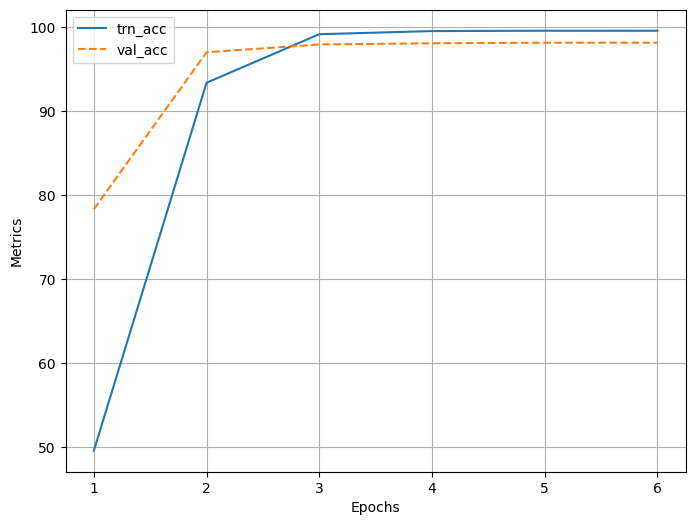

In [104]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])